# Assignment 1: Keeping Up With Social Information (Part 1)
## © Cristian Danescu-Niculescu-Mizil 2023
## CS/INFO 4300 Language and Information
## Due by midnight on Wednesday February 1st

This assignment is **individual**.

In this assignment we are practicing with post-processing on a conversational dataset taken from the reality TV show "Keeping Up With The Kardashians" and gathering some basic statistics about it. 

In the next assignment (Assignment 2) we will extend these tools to analyze conversational behavior.

**Learning Objectives**

This project aims to help you get comfortable working with the following tools / technologies / concepts:

* word tokenization
* histogram plotting using `matplotlib`
* character analysis via conversational language
* familiarize yourself with basic numpy usage

**Academic Integrity and Collaboration**

Note that these projects should be completed individually. As a result, all University-standard academic integrity guidelines must be followed.

**Guidelines**

All cells that contain the blocks that read `# YOUR CODE HERE` are editable and are to be completed to ensure you pass the test-cases. Make sure to write your code where indicated.

All cells that read `YOUR ANSWER HERE` are free-response cells that are editable and are to be completed.

You may use any number of notebook cells to explore the data and test out your functions, although you will only be graded on the solution itself.


You are unable to modify the read-only cells.

You should also use Markdown cells to explain your code and discuss your results when necessary.
Instructions can be found [here](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html).

All floating point values should be printed with **2 decimal places** precision. You can do so using the built-in round function.

**Grading**

For code-completion questions you will be graded on passing the public test cases we have included, as well as any hidden test cases that we have supplemented within a given amount of time to ensure that your logic is correct.

Your solution to A1 should finish running in **less than 5 minutes**.
For your information, it takes less than 1 minute to run our solution for the entire A1.
Also make sure to remove any **redundant print statements** to speed things up and prevent generating unnecessary outputs.

For free-response questions you will be manually graded on the quality of your answer.

**Submission**

You are expected to submit this .ipynb as your submission for Assignment 1. 

In addition please submit an html copy of the notebook (You can create this by clicking File > Download as > HTML (.html)).

#### A0 Review

Recall the learning objectives of A0:

- The Jupyter Notebook environment
- Recap of Python syntax and basic data structures
- virtualenv environment for package dependencies

We used the BeautifulSoup library to extract episode titles, timestamps, and character speech from HTML files, then stored this data in Python Dictionaries. Finally, we conducted preliminary checks of our data to test its usability (i.e. checking for duplicate transcripts and converting nickname "Rob" to "Robert").

In [1]:
import re
import json
from glob import glob
import os
from io import StringIO
from itertools import groupby
import pickle

import numpy as np
import bs4
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
# Ensure that your kernel is using Python3
assert sys.version_info.major == 3

## Preliminary Data Cleansing
**Note: The following content is for you to review to understand how we cleaned and prepared the data for the analysis below.**

We will be continuing where we left off from Assignment 0. 

### Removing duplicates
If you are to examine the original transcripts you will see that many of them are near-duplicates, but most are not *perfect* duplicates. This is problematic, because we cannot simply remove identical transcripts.  Furthermore, we cannot just throw away documents that have large overlap, because we would be throwing away the valuable data that is *not* overlapping.

We therefore have to treat the transcripts as sequences, rather than as entire documents, and just remove subsequences that overlap.

We therefore used a standard python `difflib` package to write the `find_overlaps` function:

```python
import difflib
def find_overlaps(transcript_a, transcript_b, threshold=5):
    """Find and return the indices of overlapping subsequences between the two transcripts.
    Only return overlapping sequences that consist of at least `threshold` entries."""
    
    # We consider that two transcripts overlap when the messages
    # and the speakers are the same, but not the timestamp.
    
    # Massage the transcripts to disregard timestamp information.
    # note that a tuple is hashable, so is okay to use for difflib's SequenceMatcher class.
    msgs_a = [(m['speaker'], m['text']) if m is not None else None
              for m in transcript_a]
    msgs_b = [(m['speaker'], m['text']) if m is not None else None
              for m in transcript_b]
    matcher = difflib.SequenceMatcher(None, msgs_a, msgs_b)
    return list(filter(lambda tup: tup[2] >= threshold, matcher.get_matching_blocks()))
```

We now use the function above to remove duplicate subsequences. At each step, assume we have a list of "good" transcripts that have already been processed. When considering a new transcript, we first remove all subsequences that overlap with any of the already processed ones. Then, we split up the chunks that are not removed, and consider each of them a new transcript.

```python
deduped_transcripts = []
all_keys = sorted(transcripts.keys())

for key in all_keys:
    transcript = transcripts[key]
    for _, good_transcript in deduped_transcripts:
        overlaps = find_overlaps(transcript, good_transcript)
        for idx_a, _, size in overlaps:
            transcript[idx_a:idx_a + size] = [None] * size
    
    for is_not_none, group in groupby(transcript, lambda x: x is not None):
        if is_not_none:
            subtranscript = list(group)
            deduped_transcripts.append((key, subtranscript))
```

The `deduped_transcripts` are what you are now analyzing for the rest of the assignment. 

In [3]:
## We are loading the pickle file that contains all the deduped transcripts from Assignment 0
with open('deduped_transcripts.pickle','rb') as f:
    deduped_transcripts = pickle.load(f)
## We are also loading a pickle file of the titles file that we determined in the beginning of Assignment 0
with open('titles.pickle','rb') as f:
    titles = pickle.load(f)

# Language analysis

## Identifying the words
It's time to get down to the bread-and-butter of language analysis: the words used.  For simplification, **we consider a word to be a sequence of alphabetical characters. Treat all other characters as delimiters and do not return them.**


## Question 1 (Code Completion): Tokenization 

In the cell below: *Write a function to 'tokenize' a string into the constituent words*. 

You **must** use regex to satisfy the function specification. We recommend you leverage `re.findall`. 

Hint: Check out this online regex calculator: [here](https://regex101.com/)

In [4]:
def tokenize(text):
    """Returns a list of words that make up the text.
    
    Note: for simplicity, lowercase everything.
    Requirement: Use Regex to satisfy this function
    
    Params: {text: String}
    Returns: List
    """
    # find the expression that matches a word using regex
    tokens = re.findall(r'[a-z]+', text.lower())
    return tokens

In [5]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that tokenize returns the correct output"""
assert tokenize("It's time 2 get down to the bread-and-butter") == \
    ['it', 's', 'time', 'get', 'down', 'to', 'the', 'bread', 'and', 'butter']
assert tokenize("Life, Liberty, & the Pursuit of Happiness") == \
    ['life', 'liberty', 'the', 'pursuit', 'of', 'happiness']

## Question 2 (Code Completion): Tokenization of Entire Transcript

In the cell below write a function that *tokenizes all of the text in an input transcript (given a method for tokenizing strings)*, producing a list of all tokens found in the entire transcript.

In [6]:
def tokenize_transcript(tokenize_method,input_transcript):
    """Returns a list of tokens contained in an entire transcript.
    Params: {tokenize_method: Function (a -> b),
             input_transcript: Tuple}
    Returns: List
    """
    tokens = [] 
    # input_transcript[1] is a list of dictionaries
    # each dictionary has a key 'text' and a value that is a string
    for transcript in input_transcript[1]:
        text = transcript['text']
        tokens += tokenize_method(text)

    return tokens

In [7]:
len(deduped_transcripts)

1163

In [8]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that tokenize returns the correct output"""
assert len(tokenize_transcript(tokenize,deduped_transcripts[0])) > 6000 and \
    len(tokenize_transcript(tokenize,deduped_transcripts[0])) < 7000

## Question 3 (Code Completion) Number of Tokens
In the cell below write a function to *count how many tokens are used in the deduplicated transcripts in total*

In [9]:
def num_dedup_tokens(tokenize_method,tokenize_transcript_method,input_transcripts):
    """Returns number of tokens used in an entire transcript
    Params: {tokenize_method: Function (a -> b),
             // Note: Below type means a function that takes two arguments, the first of which is a function.
             tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
             input_transcripts: Tuple List}
    Returns: Integer
    """
    token_num = 0
    for transcript in deduped_transcripts:
        token_num += len(tokenize_transcript_method(tokenize_method,transcript))
    return token_num

In [10]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that num_dedup_tokens returns the correct output"""
assert num_dedup_tokens(tokenize,tokenize_transcript,deduped_transcripts) > 200000 and \
    num_dedup_tokens(tokenize,tokenize_transcript,deduped_transcripts) < 300000

## Question 4 (Code Completion) Number of Distinct Words

In the cell below write a function to *count how many distinct words are in the deduplicated transcripts in total*. 

Hint: Use a *set*

In [11]:
def num_distinct_words(tokenize_method,tokenize_transcript_method,input_transcripts):
    """Returns number of distinct tokens used in an entire transcript
    Params: {tokenize_method: Function (a -> b),
             // Note: Below type means a function that takes two arguments, the first of which is a function.
             tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
             input_transcripts: Tuple List}
    Returns: Integer
    """
    distinct_token = set()
    for transcript in deduped_transcripts:
        distinct_token.update(tokenize_transcript_method(tokenize_method,transcript))
    return len(distinct_token)

In [12]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that num_dedup_tokens returns the correct output"""
assert num_distinct_words(tokenize,tokenize_transcript,deduped_transcripts) > 8000 and \
    num_distinct_words(tokenize,tokenize_transcript,deduped_transcripts) < 9000

# Question 5 (Code Completion) Word Episode Counts

This question is asking you to build a dictionary `word_episode_count[word]` = *number of episodes in which the word appears*. 

*Note: Keep in mind that the de-duplicated transcripts don't have unique titles!
Recall from A0 that **one episode corresponds to exactly one title** (but not necessarily to only one transcript).*

**Your code should ideally take less than 1 second (or a few seconds) to run. If it does not, then you should be able to find a better answer.**

In the cell below write a function that counts: *for each distinct (unique) word, in how many different episodes does it appear?* 

In [13]:
def build_word_episode_count(tokenize_method,tokenize_transcript_method,input_transcripts,input_titles):
    """Returns a dictionary with the number of episodes each distinct word appears
        Params: {tokenize_method: Function (a -> b),
                 // Note: Below type means a function that takes two arguments, the first of which is a function.
                 tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
                 input_transcripts: Tuple List,
                 input_titles: Dictionary}
        Returns: Dict
    """
    # a dictionary with the number of episodes each distinct word appears, initialized to 0
    distinct_tokens = set()
    for transcript in input_transcripts:
        distinct_tokens.update(tokenize_transcript_method(tokenize_method,transcript))

    word_episode_count = dict.fromkeys(distinct_tokens,0)

    # print(word_episode_count)

    # a set of distinct titles
    distinct_titles = {value for value in titles.values()}

    for title in distinct_titles:

        # a set of distinct tokens in an episode
        tokens_in_episode=set()

        # find the first transcripts with the title
        for index in range(len(input_transcripts)):
            code = input_transcripts[index][0]
            if (titles[code] == title):
                # tokenize the transcript
                tokens = tokenize_transcript_method(tokenize_method,input_transcripts[index])
                tokens_in_episode.update(tokens)
        

        # update the word_episode_count
        for token in tokens_in_episode:
            word_episode_count[token] += 1
    return word_episode_count

In [14]:
word_episode_count = build_word_episode_count(tokenize,tokenize_transcript,deduped_transcripts,titles)   

In [15]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that build_word_episode_count returns the correct output"""
assert word_episode_count['quarter'] == 2
assert word_episode_count['made'] == 40
assert word_episode_count['never'] == 49

## Question 6 (Code Completion) Distribution Analysis

For this question, you will be summarizing the word episode counts you found above by combining them into a *distribution* of the number of episodes in which words appear. That is: *how many words appear in only one episode, how many appear in two episodes, and so on?*

Specifically, you will build a dictionary `word_episode_distribution[n]` = *number of words that appear in exactly* `n` *episodes*.

In the cell below fulfill the specifications above and have the function: *produce a distribution of word episode counts*

In [16]:
word_episode_count

{'lasik': 1,
 'guy': 37,
 'prep': 2,
 'rabbits': 2,
 'nudity': 1,
 'apology': 8,
 'contact': 5,
 'funny': 31,
 'bouquet': 3,
 'firm': 4,
 'foundation': 3,
 'papers': 1,
 'managing': 5,
 'thedub': 1,
 'shortsto': 2,
 'wondered': 2,
 'beau': 2,
 'haven': 30,
 'interfere': 3,
 'squatting': 1,
 'medications': 2,
 'lows': 1,
 'tickets': 5,
 'slopes': 1,
 'taxis': 1,
 'fed': 1,
 'sickenin': 1,
 'assault': 1,
 'kimmie': 2,
 'art': 5,
 'stressful': 6,
 'lube': 2,
 'changes': 5,
 'wake': 9,
 'scan': 2,
 'duo': 1,
 'donor': 1,
 'patter': 1,
 'respect': 16,
 'beard': 1,
 'advilliqui': 1,
 'airplane': 1,
 'fish': 5,
 'rooster': 1,
 'theme': 3,
 'mothers': 1,
 'great': 44,
 'cds': 1,
 'roldan': 1,
 'enjoying': 5,
 'major': 14,
 'everyday': 2,
 'everybody': 39,
 'eyeliner': 3,
 'arabic': 1,
 'affordable': 1,
 'trademark': 1,
 'triple': 3,
 'doubled': 1,
 'giving': 14,
 'unfortunate': 1,
 'july': 2,
 'lengthens': 1,
 'laughs': 1,
 'upon': 4,
 'needed': 10,
 'trains': 1,
 'sponsored': 28,
 'jerk': 3,


In [17]:
def build_word_episode_distribution(input_word_counts):
    """Returns a dictionary that counts how many words appear in exactly a given number of episodes
        Params: {input_word_counts: Dict}
        Returns: Dict
    """
    
    # a dictionary that counts how many words appear in exactly a given number of episodes
    word_episode_distribution = dict.fromkeys(set(input_word_counts.values()),0)

    for count in input_word_counts.values():
        word_episode_distribution[count] += 1
    return word_episode_distribution

In [18]:
word_episode_distribution = build_word_episode_distribution(word_episode_count)

In [19]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that build_word_episode_distribution returns the correct output"""
assert word_episode_distribution[1] > 4000 and word_episode_distribution[1] < 4500
assert word_episode_distribution[3] > 700 and word_episode_distribution[3] < 800
assert word_episode_distribution[15] > 30 and word_episode_distribution[15] < 50

## Question 6b (Free Response): Visualizing the distribution

When working with distributions (like we're doing here), it can be helpful to *visualize* the distribution in order to get a better intuition. This can be achieved through the use of *histograms*, so in this question you will create one. 

Each bin of the histogram  (the *x axis*) should correspond to the *number of episodes* in which a word is mentioned, and the *y axis* should show the *number of words* in each bin. 

Note: Use the default matplotlib settings. You may find this tutorial helpful: https://matplotlib.org/3.0.2/tutorials/introductory/pyplot.html

Create a new cell with the histogram below. Then, give an analysis of the distribution: What do you observe?

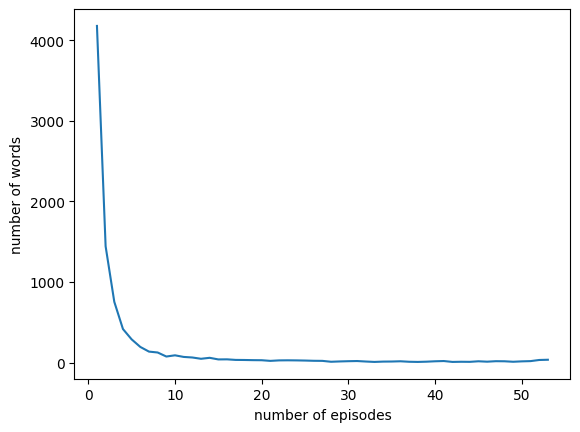

In [23]:
import matplotlib.pyplot as plt
plt.plot(list(word_episode_distribution.keys()), list(word_episode_distribution.values()))
plt.xlabel('number of episodes')
plt.ylabel('number of words')
plt.show()

## Question 7 (Code Completion): Good Types

As we have now seen, there are many *infrequent* words that occur only in one episode, and never again afterwards. When analyzing language use---for instance, if we wanted to make sense of how various characters tend to behave---we might not put too much stock in such infrequent words (maybe Kim was just having a bad day). This question deals with the step of filtering out infrequent words.

In the cell below: build an alphabetically sorted list of all words that appear in more than one episode. We'll refer to these words as *good types*.

In [29]:
def output_good_types(input_word_counts):
    """Returns a list of good types in alphabetically sorted order
        Params: {input_word_counts: Dict}
        Returns: List
    """
    good_types = []
    for word in input_word_counts:
        if input_word_counts[word] > 1:
            good_types.append(word)
    return sorted(good_types)

In [30]:
good_types = output_good_types(word_episode_count)
n_good_types = len(good_types)

n_good_types

4517

In [31]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that output_good_types returns the correct output"""
assert n_good_types > 4500 and n_good_types < 5000
assert good_types[0:5] == ['a','aah','ability','able','about']

## Question 7b (Free Response): Good Types

In the cell below answer the following: *How many good_types there are? What are the first 10 in alphabetical order?*

Please write your answer in code and use Python's `print()` function, **NOT** markdown.

In [32]:
for i in range (0,10):
    print(good_types[i])

a
aah
ability
able
about
absolute
absolutely
absurd
accent
accept


From now on, the use of array data structures from `numpy` is required in some places. If you've never used numpy before, it will take some time to get used to. In general, numpy is a library that you can use to handle vector/matrix/tensor operations, including creation, modification, and compositions (add, sub, mul, etc.). For example, try running the following code:

In [33]:
A = np.array([[1,2,3], [4,6,2]]) 
B = np.array([[1,2],[5,3],[1,1]])
print(A) #A is a 2x3 matrix
print(B) #B is a 3x2 matrix
print(A[0,2]) # Prints the value contained in the first row, third column of matrix A
print(A.dot(B)) #A.dot(B) multiplies the two matrices, producing a 2 by 2 matrix
print(np.sum(A, axis=0)) #np.sum(A, axis=0) sums along columns
print(np.sum(B, axis=1)) #np.sum(B, axis=1) sums along rows

[[1 2 3]
 [4 6 2]]
[[1 2]
 [5 3]
 [1 1]]
3
[[14 11]
 [36 28]]
[5 8 5]
[3 8 2]


You're welcome to find your own resources to learn more about numpy (there are lots of them) but one good introduction is [Justin Johnson's writeup](http://cs231n.github.io/python-numpy-tutorial/#numpy).

We will be using vectors and arrays with *n_good_types* columns, such that each good type corresponds to a column, in alphabetical order.

## Question 8 (Code Completion): Word Frequencies

Previously, we characterized words according to how many episodes they appeared in. For this question, we will take a different approach: computing the rate (or *frequency*) at which a word appears across the entire corpus (note: a corpus is a collection of written texts, in this case the transcripts of a reality TV show).

In the cell below, complete the function to *find the word frequency of all "good types"* in descending order.

For this question only, **round your solution to 5 decimals**.

What can we say about the most frequently used words? Briefly consider, would you expect to find the same ordering of frequent words in, say, the NY Times?

In [49]:
def create_ranked_good_types(tokenize_method,tokenize_transcript_method,input_transcripts,input_good_types):
    """Returns a list of good types in reverse sorted order in the form:
        [(word_1,word_frequency_1),
        ...
        (word_10,word_frequency_10)]
        Params: {tokenize_method: Function (a -> b),
                 // Note: Below type means a function that takes two arguments, the first of which is a function.
                 tokenize_transcript_method: Function ((Function(a -> b), c) -> d),
                 input_transcripts: Tuple List,
                 input_good_types: List}
        Returns: List
    """
    word_frequency = dict.fromkeys(input_good_types,0)

    # total number of corpus
    total_num = 0

    for transcript in input_transcripts:
        tokens = tokenize_transcript_method(tokenize_method,transcript)
        for token in tokens:
            total_num += 1
            if token in word_frequency:
                word_frequency[token] += 1
    


    # calculate the frequency of each word
    for word in word_frequency:
        word_frequency[word] = round(word_frequency[word]/total_num,5)

    # sort the word_frequency in reverse order
    ranked_good_types = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)



    return ranked_good_types

In [50]:
ranked_frequencies = create_ranked_good_types(tokenize,tokenize_transcript,deduped_transcripts,good_types)

In [51]:
ranked_frequencies

[('i', 0.04858),
 ('you', 0.03797),
 ('to', 0.03056),
 ('s', 0.02312),
 ('the', 0.02148),
 ('and', 0.02085),
 ('a', 0.01907),
 ('it', 0.01785),
 ('that', 0.01528),
 ('t', 0.01248),
 ('like', 0.01142),
 ('m', 0.01108),
 ('this', 0.01069),
 ('is', 0.01063),
 ('my', 0.00976),
 ('just', 0.00952),
 ('of', 0.00909),
 ('we', 0.00875),
 ('so', 0.00861),
 ('what', 0.0085),
 ('in', 0.00835),
 ('me', 0.00798),
 ('re', 0.00794),
 ('have', 0.00788),
 ('do', 0.00713),
 ('for', 0.00681),
 ('don', 0.00669),
 ('know', 0.00668),
 ('with', 0.00658),
 ('not', 0.00657),
 ('are', 0.00628),
 ('be', 0.00626),
 ('on', 0.00622),
 ('she', 0.00607),
 ('get', 0.00564),
 ('go', 0.00551),
 ('really', 0.00528),
 ('all', 0.00527),
 ('your', 0.0051),
 ('going', 0.00493),
 ('no', 0.00493),
 ('want', 0.00492),
 ('her', 0.00481),
 ('he', 0.0046),
 ('can', 0.00454),
 ('but', 0.00411),
 ('up', 0.00402),
 ('out', 0.00397),
 ('here', 0.0039),
 ('think', 0.00383),
 ('was', 0.00374),
 ('right', 0.00368),
 ('okay', 0.00361),
 ('

In [52]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_ranked_good_types returns the correct output"""
words_only = [word for word, freq in ranked_frequencies]
frequencies_only = np.array([freq for word, freq in ranked_frequencies])
assert words_only[0:2] == ['i','you']
assert np.isclose(frequencies_only[0:2], 
            np.array([0.04858, 0.03797]), atol=1e-3).all()

Note: the autograder uses some additional numpy utility functions. You don't need to be familiar with these right now, but in case you are curious:

- `np.isclose` is a useful function for comparing floats, that gets around the problem of floating-point imprecision;
- `.all()` is True whenever all the entries of a boolean array are True.


## Characterizing characters' language

Moving on, we will only be considering a subset of characters, arguably the most important ones.

In [53]:
good_speakers = [u'BRUCE',
                 u'JONATHAN',
                 u'KHLOE',
                 u'KIM',
                 u'KOURTNEY',
                 u'KRIS',
                 u'ROBERT',
                 u'SCOTT']

n_speakers = len(good_speakers)

## Question 9 (Code Completion): Character Word Occurrences

In the cell below you will be asked to determine *how often each word is said by each character*.

This function **requires** you to return a numpy array of shape `n_speakers` rows by `n_good_types` columns, such that the entry `(i,j)` indicates how many times speaker i says word j. **You will lose points if you do not use numpy!**

In [63]:
deduped_transcripts[0][1]

[{'timestamp': '00:00:23',
  'speaker': 'KHLOE',
  'text': "You don't have your own credit card?"},
 {'timestamp': '00:00:25',
  'speaker': 'BRUCE',
  'text': "I don't even have a credit card."},
 {'timestamp': '00:00:26', 'speaker': 'BRUCE', 'text': 'I know.'},
 {'timestamp': '00:00:27',
  'speaker': 'KHLOE',
  'text': 'You are such a little girl.'},
 {'timestamp': '00:00:31', 'speaker': 'BRUCE', 'text': 'I know.'},
 {'timestamp': '00:00:32', 'speaker': 'BRUCE', 'text': "I'm a wuss, yeah."},
 {'timestamp': '00:00:33',
  'speaker': 'BRUCE',
  'text': 'When it comes to that stuff.'},
 {'timestamp': '00:00:34', 'speaker': 'KHLOE', 'text': "You're a puss."},
 {'timestamp': '00:00:35', 'speaker': 'BRUCE', 'text': "I'm a puss."},
 {'timestamp': '00:00:36',
  'speaker': 'KHLOE',
  'text': 'I feel so bad that you need to, like, ask me for money.'},
 {'timestamp': '00:00:39', 'speaker': 'BRUCE', 'text': 'Yeah, I know.'},
 {'timestamp': '00:00:40', 'speaker': 'BRUCE', 'text': 'I feel bad, too.'

In [65]:
def create_word_occurrence_matrix(
    tokenize_method,
    input_transcripts,
    input_speakers,
    input_good_types):
    """Returns a numpy array of shape n_speakers by n_good_types such that the 
    entry (ij) indicates how often speaker i says word j.
    
    Params: {tokenize_method: Function (a -> b),
             input_transcripts: Tuple List,
             input_speakers: List,
             input_good_types: List}
    Returns: Numpy Array
    """

    # initialize the matrix
    word_occurrence_matrix = np.zeros((n_speakers,n_good_types))

    for transcript in input_transcripts:
        # deal with each sentence
        for sentence in transcript[1]:
            # get the speaker name
            speaker = sentence['speaker']
            if speaker in input_speakers:
                # tokenize the sentence
                tokens = tokenize_method(sentence['text'])
                for token in tokens:
                    if token in input_good_types:
                        word_occurrence_matrix[input_speakers.index(speaker)][input_good_types.index(token)] += 1
        
    return word_occurrence_matrix


array([[542.,   0.,   0., ...,   0.,   0.,   0.],
       [122.,   0.,   0., ...,   1.,   0.,   1.],
       [951.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [927.,   0.,   0., ...,   0.,   1.,   0.],
       [410.,   0.,   1., ...,   0.,   0.,   0.],
       [268.,   4.,   0., ...,   0.,   0.,   1.]])

In [117]:
word_matrix = create_word_occurrence_matrix(tokenize,deduped_transcripts,good_speakers,good_types)

In [67]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_word_freq_array returns the correct output"""
assert sum(word_matrix[0]) > 26000.0
assert sum(word_matrix[:,3]) > 40 and sum(word_matrix[:,3]) < 50
assert type(word_matrix) == np.ndarray

## Question 9b (Free Response): Character Word Occurrences

In the cell below, output the *top 10 most occurring words used by each character*, again in descending order, in the following format (if you encounter ties, then any ordering is acceptable):

**Answer format**:

```
CHARACTER_NAME_A
word_1
word_2
...
word_10

CHARACTER_NAME_B
word_1
word_2
...
word_10

...
```

In [116]:
for speaker in range(n_speakers):
    print(good_speakers[speaker])
    word_array = np.array(word_matrix[speaker])
    for i in range(10):
        index = np.argmax(word_array)
        print(good_types[index])
        word_array[index] = 0
    

BRUCE
t
is
of
what
m
in
re
know
all
on
JONATHAN
m
t
is
of
we
that
what
are
don
me
KHLOE
t
is
this
m
my
so
just
me
in
of
KIM
m
t
my
just
so
this
is
me
have
for
KOURTNEY
like
is
we
this
my
just
m
so
in
don
KRIS
of
what
is
have
this
re
so
in
my
really
ROBERT
m
t
her
my
get
of
like
this
got
know
SCOTT
what
me
m
in
do
like
is
just
this
re


## Question 9c (Code Completion): Character Word Occurrences

Using your `word_matrix`, identify the characters (in descending order of number of occurrences) who have said **all** of the following words: `["brother", "book", "best"]`. 

Please note: a character must have spoken each word at least once to be included in your answer (if you encounter ties, then any ordering is acceptable).

In the cell below, output your answer in the following format:

**Answer format**:

```
brother
CHARACTER_NAME_A occurrences_brother_A
CHARACTER_NAME_B occurrences_brother_B
...

book
CHARACTER_NAME_A occurrences_book_A
CHARACTER_NAME_B occurrences_book_B
...

best
CHARACTER_NAME_A occurrences_best_A
CHARACTER_NAME_B occurrences_best_B
...
```


In [79]:
interesting_words = ["brother", "book", "best"]

In [97]:
interesting_words_index = [good_types.index(word) for word in interesting_words]
word_array = word_matrix[...,interesting_words_index]

# print(word_array)

sayitall_speaker = []

for speaker in range(n_speakers):
    if(word_array[speaker][0] > 0 and  word_array[speaker][1] > 0 and word_array[speaker][1] > 0 ):
        sayitall_speaker.append(good_speakers[speaker])

for word in interesting_words:
    print(word)
    for speaker in sayitall_speaker:
        print(speaker, int(word_array[good_speakers.index(speaker)][interesting_words.index(word)]))
    print('')


brother
BRUCE 1
KIM 44
KOURTNEY 3
KRIS 1
SCOTT 2

book
BRUCE 2
KIM 4
KOURTNEY 1
KRIS 6
SCOTT 2

best
BRUCE 16
KIM 20
KOURTNEY 20
KRIS 27
SCOTT 4



## Question 10 (Code Completion): Word Character Counts

In the questions below you will now be asked to determine *how many characters have used a specific word*? For example, how many characters have ever said "botox" in the show?

The function below will require you to use the `word_matrix` from above to return a 1-D numpy array that reports the number of `good_speakers` that have uttered each word within `good_types`.
The i-th entry of your answer array `word_character_count_array[i]` should be the number of characters that have uttered the word `good_types[i]`.

Hint! Numpy is your friend :-)

In [132]:
def create_word_character_count_array(word_freq_matrix):
    """Returns a numpy array of shape (n_good_types,) such that the 
    entry i indicates how many good_speakers have uttered word i.
    
    Params: { word_freq_matrix: a numpy matrix of shape (n_speakers, n_good_types) }
    
    Hint: You may want to consult the numpy documentation to make this easy.
    """
    word_freq_matrix = word_freq_matrix.astype(bool).astype(int)
    word_character_count_array = np.sum(word_freq_matrix, axis=0)
    return word_character_count_array

In [133]:
word_matrix

array([[542.,   0.,   0., ...,   0.,   0.,   0.],
       [122.,   0.,   0., ...,   1.,   0.,   1.],
       [951.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [927.,   0.,   0., ...,   0.,   1.,   0.],
       [410.,   0.,   1., ...,   0.,   0.,   0.],
       [268.,   4.,   0., ...,   0.,   0.,   1.]])

In [134]:
word_character_count_array = create_word_character_count_array(word_matrix)
word_character_count_array

array([8, 2, 2, ..., 1, 1, 2])

In [127]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_character_word_count_array returns the correct output"""
assert type(word_character_count_array) == np.ndarray
assert word_character_count_array[0] == 8
assert word_character_count_array[1] == 2

## Question 10b (Free Response): Word Character Counts

What are the first 10 words (sorted in alphabetical order) that are said by **at least 5** characters?

In the cell below, give your answer in the following format:

**Answer format**:

```
word_1
word_2
...
word_10
```


array([3063, 1191, 4049, ..., 2767, 2714,    0])

In [142]:
index = 0
for i in range(10):
    while not(word_character_count_array[index] >= 5):
        index += 1
    print(good_types[index])
    index += 1

a
able
about
absolutely
accept
access
account
act
acting
active


## Question 11 (Code Completion): Specific Word Usage by Character

The exercise in 9b didn't help much in understanding each character's diction, because common words are used too commonly anyway. We want to give more weight to less frequent (that is, more "specific") words, as they carry more information on the particularities of the characters.

A simple way to do this is to score the words according to the ratio between how often a given character said the word and how often any of the *good speakers* said it.  

This can be accomplished by dividing each column in the `word_array` matrix by its sum.

**Note: as some words might never be said by the key characters we are considering, add 1 to the sum of each column to avoid division by 0**

In the cell below, write a function that uses the methodology described above to return a weighted numpy array of *specific* words used by each character.

In [ ]:
def create_weighted_word_freq_array(input_word_array):
    """Returns a numpy array of shape n_speakers by n_good_types such that the 
    entry (ij) indicates how often speaker i says word j weighted by the above ratio.
    
    Note: You must add 1 to the sum of each column to avoid divison by 0 issues.
    
    Params: {input_word_array: Numpy Array}
    Returns: Numpy Array
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
weighted_words = create_weighted_word_freq_array(word_matrix)

In [ ]:
# This is an autograder test. Here we can test the function you just wrote above.
"""Check that create_word_freq_array returns the correct output"""
assert sum(weighted_words[:,7]) > 0.7
assert type(weighted_words) == np.ndarray

## Question 11b (Free Response): Specific Word Usage by Character

Use the next cell to output the top 10 most *specific* words (in descending order) used by each character in the following format:

**Answer format**:

```
CHARACTER_NAME_A
score_1 word_1
score_2 word_2
...
score_10 word_10

CHARACTER_NAME_B
score_1 word_1
score_2 word_2
...
score_10 word_10

...
```

In [ ]:
print_top(weighted_words, show_scores=True)

## Question 11c (Free Response): Specific Word Usage by Character

Now we can start to see interesting differences between the characters.

Create a new Markdown cell below and use it to write a paragraph discussing the differences you find most striking.

This is the end of Assignment 1